In [1]:
import numpy as np
import torch
from digits_io import *
from model import *
from pathlib import Path
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /tmp/matplotlib-c1f0agaq because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
train_file_path = Path.home() / "RANCZLAB-NAS/iakov/heidelberg_digits/shd_train.h5"

In [3]:
inds = get_digit_inds(train_file_path, speaker_id=0, digit=9)
units, times, trials_num = get_digit_data(train_file_path, inds)

In [4]:
duration = 1 # seconds
resampling_frequency = 1000 # Hz
unit_padding_length = 650 # Number of units to pad recordings to

trimmed_units, trimmed_times = trim_to_length(units, times, duration)
t, spikes = resample(trimmed_units, trimmed_times, duration, resampling_frequency, pad_length=unit_padding_length)

In [5]:
trial_id = 0

In [6]:
print('FORMAT 1: Original Heidelberg digits dataset')
print('Unit IDs', units[trial_id])
print('Spike Times', times[trial_id])

FORMAT 1: Original Heidelberg digits dataset
Unit IDs [446 167 176 ... 521 339 366]
Spike Times [0.000e+00 5.417e-04 3.500e-03 ... 7.246e-01 7.290e-01 7.300e-01]


In [7]:
print('FORMAT 1.2: plt.eventplot')
print('Nested spike times', single_trial_plt_conversion(units[trial_id], times[trial_id], data_format=1)[:5], '...')

FORMAT 1.2: plt.eventplot
Nested spike times [[0.566, 0.689], [0.01938], [0.5566], [0.24, 0.314], [0.0407]] ...


In [8]:
print(f'FORMAT 2: SNN-friendly trimmed to {duration}s, padded to {unit_padding_length} units and resampled at {resampling_frequency}Hz:')
print(f'{resampling_frequency}Hz time array\n {t[trial_id][:5]} ...')
print(f'Binary {spikes[trial_id].shape[0]}x{spikes[trial_id].shape[1]} array\n {spikes[trial_id]}')

FORMAT 2: SNN-friendly trimmed to 1s, padded to 650 units and resampled at 1000Hz:
1000Hz time array
 [0.       0.001001 0.002002 0.003003 0.004004] ...
Binary 1000x650 array
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


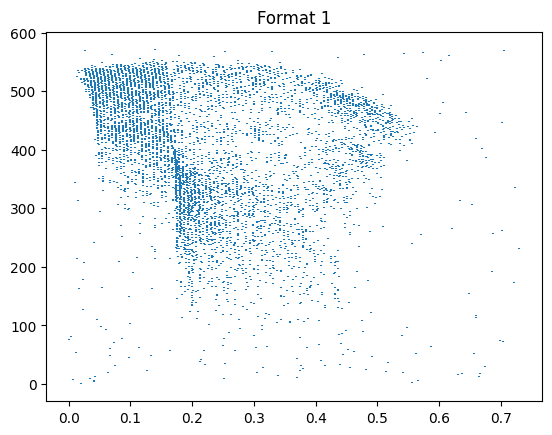

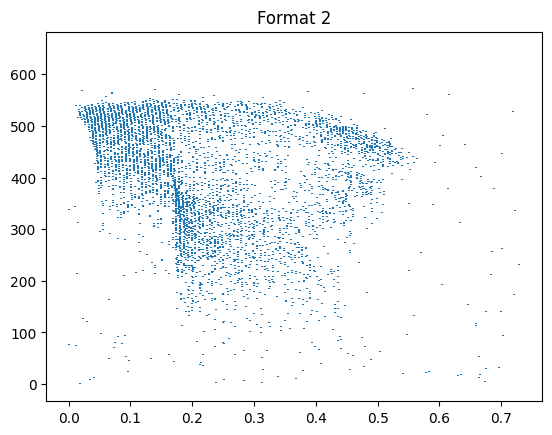

In [9]:
plt.title('Format 1')
plt.eventplot(single_trial_plt_conversion(units[trial_id], times[trial_id], data_format=1))
plt.show()
plt.title('Format 2')
plt.eventplot(single_trial_plt_conversion(t[trial_id], spikes[trial_id], data_format=2))
plt.show()

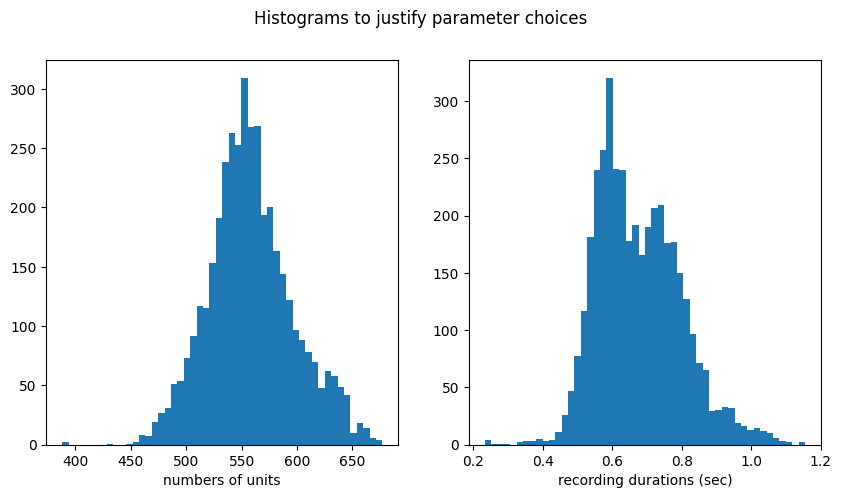

Optimal choice: 650 units and 1 second duration


In [10]:
lengths = []
for speaker in range(20):
    for digit in range(10):
        inds = get_digit_inds(train_file_path, speaker_id=speaker, digit=digit)
        units, _, trials = get_digit_data(train_file_path, inds)
        for i in range(trials):
            lengths.append(np.unique(units[i]).shape[0])



durations = []
for speaker in range(20):
    for digit in range(10):
        inds = get_digit_inds(train_file_path, speaker_id=speaker, digit=digit)
        _, times, trials = get_digit_data(train_file_path, inds)
        for i in range(trials):
            durations.append(times[i][-1])
            

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

fig.suptitle('Histograms to justify parameter choices')
            
ax[0].hist(lengths, bins=50)
ax[0].set_xlabel('numbers of units')

ax[1].hist(durations, bins=50)
ax[1].set_xlabel('recording durations (sec)')
plt.show()

print("Optimal choice: 650 units and 1 second duration")

In [11]:
dtype = np.int8

In [12]:
# single_digits = {}
# for digit in range(10):
#     t, spikes = get_format_2_data(train_file_path, 0, digit, duration, resampling_frequency, unit_padding_length)
#     single_digits[digit] = spikes.astype(dtype)

In [13]:
# np.save(Path.home()/'RANCZLAB-NAS/iakov/single_digits.npy', single_digits)
single_digits = np.load(Path.home()/'RANCZLAB-NAS/iakov/single_digits.npy', allow_pickle=True).item()

In [14]:
l = []
for v in single_digits.values():
    l.append(v.shape[0])
l

[48, 47, 48, 47, 46, 46, 49, 44, 45, 46]

In [15]:
# Quickest and easiest approach:
# Construct as many unique sequences for each starting digits as many trials there are
# in the digit with the smallest number of trials
# 44 is the smallest
# 44 * 10 starting digits = 440 sequences of training data
# Further, permuting through trials correctly can increase the number of sequences

In [16]:
per_digit_seq_num = np.min(l)
per_digit_seq_num

44

In [17]:
def get_next_ind(current_ind):
    if current_ind < 9:
        next_ind = current_ind + 1
    elif current_ind == 9:
        next_ind = 0
    return next_ind

In [18]:
# sequences = []
# for starting_digit in range(10): # loop of starting digits
#     for unique_seq_i in range(per_digit_seq_num): # loop of unique trials
#         spikes = single_digits[starting_digit][unique_seq_i]
#         ind = starting_digit
#         for seq_i in range(9): # inner sequence loop
#             ind = get_next_ind(ind)
#             spikes = np.concatenate((spikes, single_digits[ind][unique_seq_i]))
#         sequences.append(spikes)
# sequences = np.array(sequences).astype(dtype)

In [19]:
# np.save(Path.home()/'RANCZLAB-NAS/iakov/sequences.npy', sequences)
sequences = np.load(Path.home()/'RANCZLAB-NAS/iakov/sequences.npy', allow_pickle=True)

In [20]:
len(sequences)

440

In [21]:
sequences.shape

(440, 10000, 650)

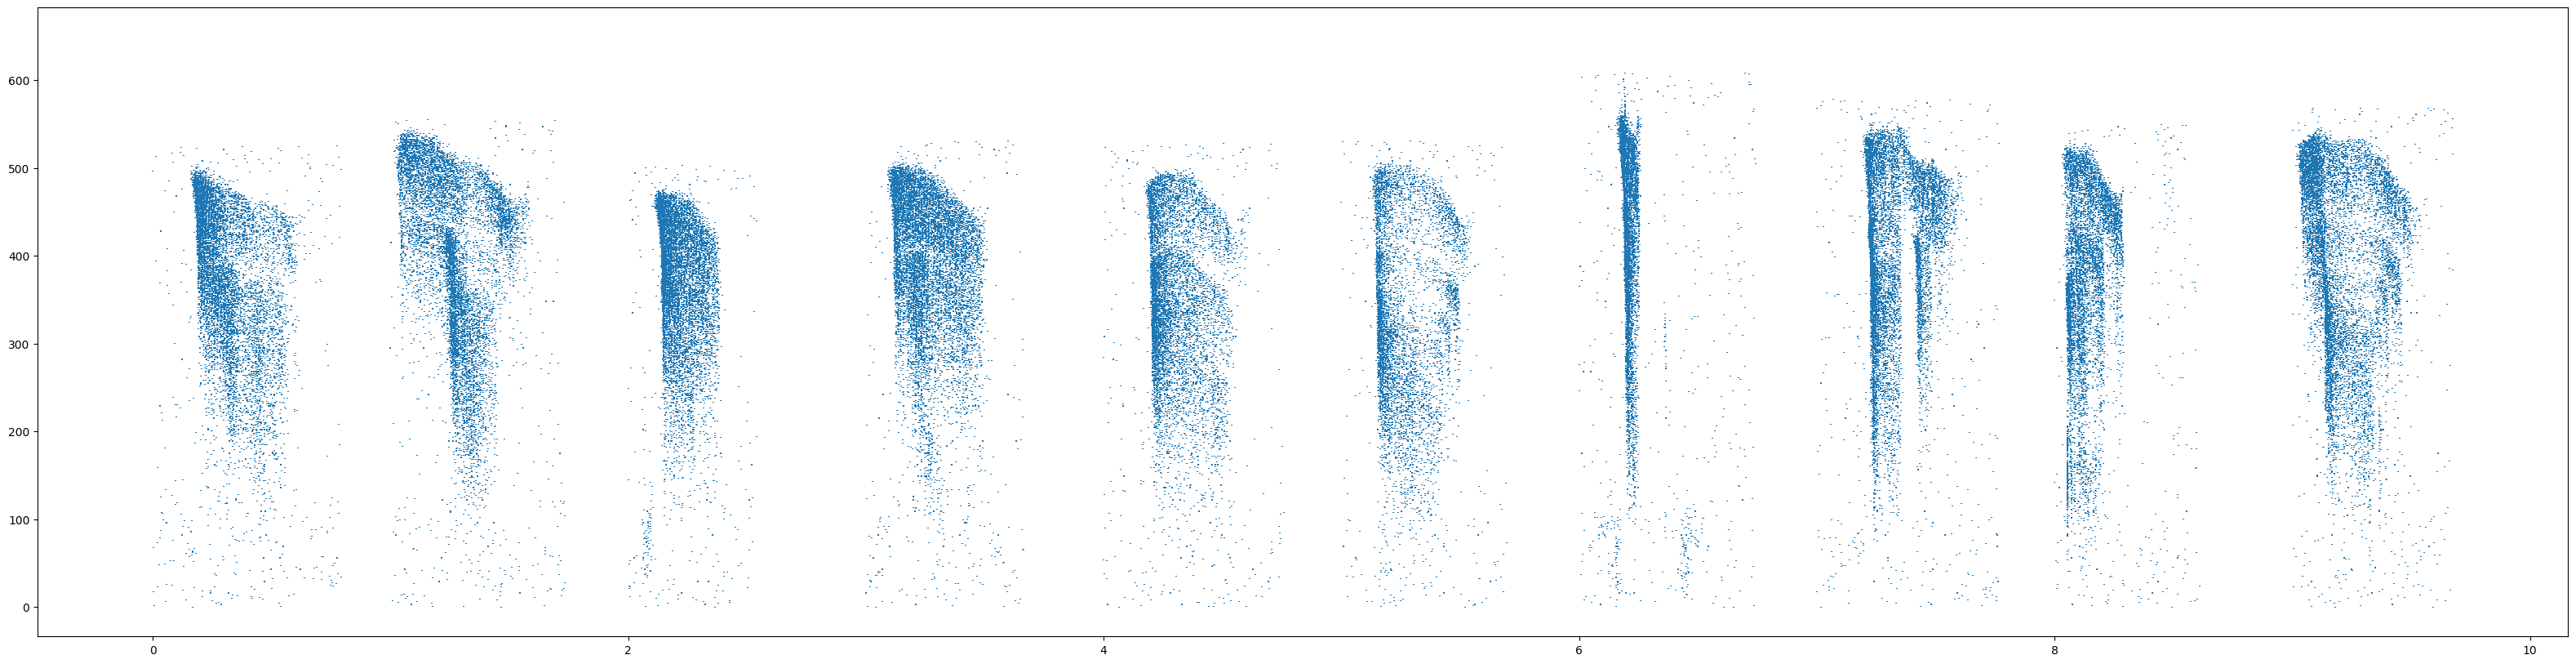

In [22]:
t = get_time_array(10, resampling_frequency)
plt.figure(figsize=(40,10))
plt.eventplot(single_trial_plt_conversion(t, sequences[43], data_format=2))
plt.show()

In [23]:
save_weights_path = Path.home() / 'RANCZLAB-NAS/iakov/v1_weights_20_dec'

In [24]:
input_tensor = torch.Tensor(sequences)
input_tensor = input_tensor[torch.randperm(input_tensor.shape[0])] # row shuffling

In [25]:
input_tensor.shape

torch.Size([440, 10000, 650])

In [26]:
model = SNNModel(batch_size = 44, hidden_units = 650, num_timesteps = 10000, step_length = 1/10000, device = torch.device('cuda'), dtype = torch.float)

In [27]:
model.init_parameters()

In [ ]:
losses = model.train(input_tensor, lr = 0.001, num_epochs = 100, save_weights_path = save_weights_path)

epoch 1: 100%|██████████| 10/10 [01:01<00:00,  6.17s/it]


Epoch 1: loss=5682.75371


epoch 2: 100%|██████████| 10/10 [01:03<00:00,  6.40s/it]


Epoch 2: loss=3486.24333


epoch 3: 100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Epoch 3: loss=1833.51638


epoch 4: 100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Epoch 4: loss=835.01651


epoch 5: 100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Epoch 5: loss=270.27756


epoch 6: 100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Epoch 6: loss=107.52550


epoch 7: 100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Epoch 7: loss=nan


epoch 8: 100%|██████████| 10/10 [01:03<00:00,  6.39s/it]


Epoch 8: loss=nan


epoch 9: 100%|██████████| 10/10 [01:05<00:00,  6.54s/it]


Epoch 9: loss=nan


epoch 10: 100%|██████████| 10/10 [01:01<00:00,  6.13s/it]


Epoch 10: loss=nan


epoch 11: 100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Epoch 11: loss=nan


epoch 12: 100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


Epoch 12: loss=nan


epoch 13: 100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Epoch 13: loss=nan


epoch 14: 100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Epoch 14: loss=nan


epoch 15: 100%|██████████| 10/10 [01:04<00:00,  6.44s/it]


Epoch 15: loss=nan


epoch 16: 100%|██████████| 10/10 [01:01<00:00,  6.19s/it]


Epoch 16: loss=nan


epoch 17: 100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Epoch 17: loss=nan


epoch 18: 100%|██████████| 10/10 [01:02<00:00,  6.21s/it]


Epoch 18: loss=nan


epoch 19: 100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Epoch 19: loss=nan


epoch 20: 100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


Epoch 20: loss=nan


epoch 21: 100%|██████████| 10/10 [00:58<00:00,  5.89s/it]


Epoch 21: loss=nan


epoch 22: 100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Epoch 22: loss=nan


epoch 23: 100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


Epoch 23: loss=nan


epoch 24: 100%|██████████| 10/10 [01:02<00:00,  6.21s/it]


Epoch 24: loss=nan


epoch 25: 100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Epoch 25: loss=nan


epoch 26: 100%|██████████| 10/10 [01:01<00:00,  6.11s/it]


Epoch 26: loss=nan


epoch 27: 100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


Epoch 27: loss=nan


epoch 28: 100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Epoch 28: loss=nan


epoch 29: 100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


Epoch 29: loss=nan


epoch 30: 100%|██████████| 10/10 [01:02<00:00,  6.30s/it]


Epoch 30: loss=nan


epoch 31: 100%|██████████| 10/10 [01:01<00:00,  6.15s/it]


Epoch 31: loss=nan


epoch 32: 100%|██████████| 10/10 [01:00<00:00,  6.09s/it]


Epoch 32: loss=nan


epoch 33: 100%|██████████| 10/10 [01:04<00:00,  6.44s/it]


Epoch 33: loss=nan


epoch 34: 100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Epoch 34: loss=nan


epoch 35: 100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Epoch 35: loss=nan


epoch 36: 100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Epoch 36: loss=nan


epoch 37: 100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Epoch 37: loss=nan


epoch 38: 100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Epoch 38: loss=nan


epoch 39: 100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


Epoch 39: loss=nan


epoch 40: 100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Epoch 40: loss=nan


epoch 41: 100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Epoch 41: loss=nan


epoch 42: 100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Epoch 42: loss=nan


epoch 43: 100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Epoch 43: loss=nan


epoch 44: 100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Epoch 44: loss=nan


epoch 45: 100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Epoch 45: loss=nan


epoch 46: 100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Epoch 46: loss=nan


epoch 47: 100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


Epoch 47: loss=nan


epoch 48: 100%|██████████| 10/10 [01:01<00:00,  6.10s/it]


Epoch 48: loss=nan


epoch 49: 100%|██████████| 10/10 [01:01<00:00,  6.19s/it]


Epoch 49: loss=nan


epoch 50: 100%|██████████| 10/10 [01:04<00:00,  6.40s/it]


Epoch 50: loss=nan


epoch 51: 100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Epoch 51: loss=nan


epoch 52: 100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


Epoch 52: loss=nan


epoch 53: 100%|██████████| 10/10 [01:02<00:00,  6.25s/it]


Epoch 53: loss=nan


epoch 54: 100%|██████████| 10/10 [01:03<00:00,  6.33s/it]


Epoch 54: loss=nan


epoch 55: 100%|██████████| 10/10 [01:02<00:00,  6.22s/it]


Epoch 55: loss=nan


epoch 56: 100%|██████████| 10/10 [01:03<00:00,  6.39s/it]


Epoch 56: loss=nan


epoch 57: 100%|██████████| 10/10 [01:03<00:00,  6.31s/it]


Epoch 57: loss=nan


epoch 58: 100%|██████████| 10/10 [01:02<00:00,  6.26s/it]


Epoch 58: loss=nan


epoch 59: 100%|██████████| 10/10 [01:03<00:00,  6.30s/it]


Epoch 59: loss=nan


epoch 60: 100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


Epoch 60: loss=nan


epoch 61: 100%|██████████| 10/10 [01:03<00:00,  6.30s/it]


Epoch 61: loss=nan


epoch 62: 100%|██████████| 10/10 [01:02<00:00,  6.29s/it]


Epoch 62: loss=nan


epoch 63:  50%|█████     | 5/10 [00:31<00:32,  6.47s/it]

In [28]:
weights_path = Path.home() / 'RANCZLAB-NAS/iakov/v1_weights_20_dec/epoch99_v1_matrix.npy'
model.load_weights(np.load(weights_path))

In [29]:
plt.plot(losses)

NameError: name 'losses' is not defined

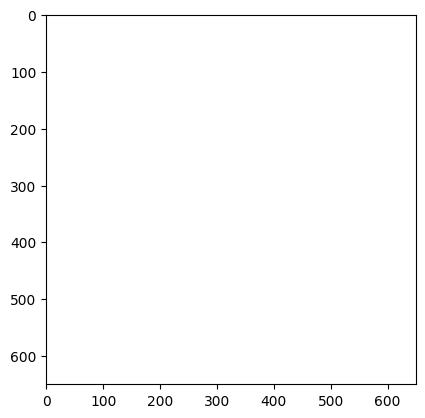

In [31]:
plt.imshow(model.v1.cpu().detach().numpy())
plt.show()
# plt.hist(model.v1.cpu().detach().numpy().flatten(), bins=50)
# plt.show()

In [ ]:
# TEST
mem_rec, spk_rec = model.run_snn(input_tensor[:44].cuda())

In [ ]:
trial_id = 0
xlim = [0, 0.5]

t = get_time_array(10, resampling_frequency)

plt.title('Input spikes')
plt.eventplot(single_trial_plt_conversion(t, input_tensor[trial_id].cpu().numpy(), data_format=2))
plt.xlim(xlim)
plt.show()

plt.title('Spiking activity of hidden units')
plt.eventplot(single_trial_plt_conversion(t, spk_rec[trial_id].cpu().detach().numpy(), data_format=2))
plt.xlim(xlim)
plt.show()